Time series forecasting  maleria prevelance in Muleba using ARIMA

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [0]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')
data = pd.read_csv( 'https://raw.githubusercontent.com/Mashiku7/Control-Anopheles-Malaria-Project-CAMP/master/CDO6199837732377EnviromentData.csv',  index_col='YEAR',  parse_dates = ['YEAR'], date_parser = dateparse)


Examine Data

In [35]:
data.describe()

,STN,WBAN,TEMP,STP,ANOPHELES
count,337.0,337.0,337.0,337.0,337.0
mean,637290.0,99999.0,71.9,887.6,2.7
std,0.0,0.0,2.0,1.2,0.4
min,637290.0,99999.0,66.5,884.1,1.2
25%,637290.0,99999.0,70.6,886.9,2.8
50%,637290.0,99999.0,72.0,887.7,2.8
75%,637290.0,99999.0,73.1,888.4,2.8
max,637290.0,99999.0,77.8,890.8,2.8


In [36]:
data.index

DatetimeIndex(['2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10', '2015-01-11', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2015-12-22', '2015-12-23', '2015-12-24', '2015-12-25',
               '2015-12-26', '2015-12-27', '2015-12-28', '2015-12-29',
               '2015-12-30', '2015-12-31'],
              dtype='datetime64[ns]', name='YEAR', length=337, freq=None)

In [37]:
ts = data["ANOPHELES"] 
ts.head(10)

YEAR
2015-01-05   2.8
2015-01-06   2.8
2015-01-07   2.8
2015-01-08   2.8
2015-01-09   2.8
2015-01-10   2.8
2015-01-11   2.8
2015-01-13   2.8
2015-01-14   2.8
2015-01-15   2.8
Name: ANOPHELES, dtype: float64

In [39]:
ts['2015-01-14']

2.8169014160000003

Checking the stations

we have Station ID, Day(Time stamp) and Density time series data then create the time-series

Mean = constant over all intervals.
Variance = constant over all intervals.

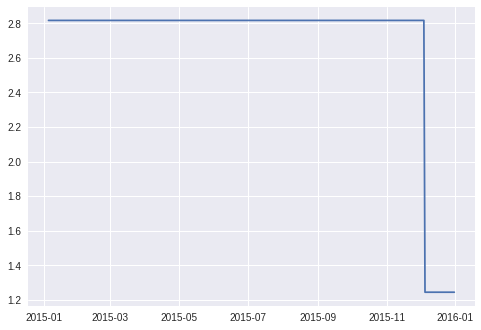

In [40]:
plt.plot(ts)

In [45]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


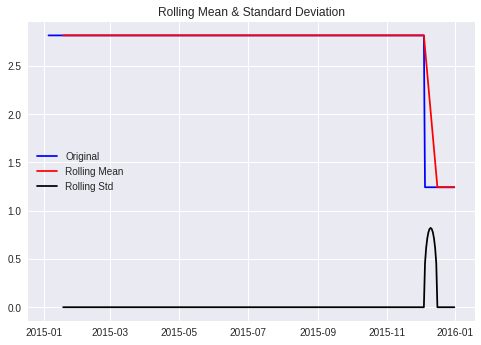

Results of Dickey-Fuller Test:
Test Statistic                 -0.3
p-value                         0.9
#Lags Used                      0.0
Number of Observations Used   336.0
Critical Value (1%)            -3.4
Critical Value (5%)            -2.9
Critical Value (10%)           -2.6
dtype: float64


In [46]:
test_stationarity(ts)

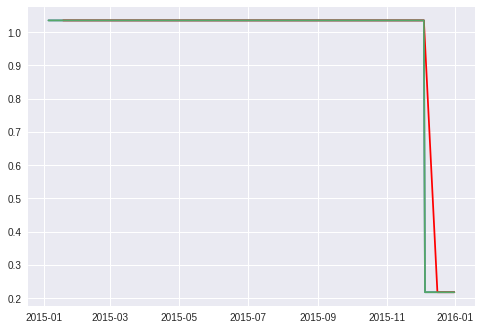

In [47]:
ts_log = np.log(ts)
plt.plot(ts_log)
ts_smooth = ts_log.rolling(window = 12).mean()
plt.plot(ts_smooth, color = 'red')
plt.plot(ts_log)
plt.show()


##Forecasting
Lets make model on the TS after differencing as it is a very popular technique. Also, its relatively easier to add noise and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations:

A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.
A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.
Let me give you a brief introduction to ARIMA. I won’t go into the technical details but you should understand these concepts in detail if you wish to apply them more effectively. ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.
Selecting p, q, and d values

Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [0]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [50]:
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

NameError: ignored

In [0]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

In [0]:
from statsmodels.tsa.arima_model import ARIMA

p = 2, q = 2

Now AR, MA & ARIMA models for the data

AR Model

In [0]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff)**2))

In [0]:
# MA model

model = ARIMA(ts_log, order=(0, 1, 2))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff)**2))

In [0]:
# ARIMA model
# Goal for the forecase was RSS: 1.275 and 

model = ARIMA(ts_log, order=(2, 1, 2))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff)**2))

In [0]:
preds = pd.Series(results_AR.fittedvalues, copy = True)
preds_cumsum = preds.cumsum()
print preds_cumsum.head()

In [0]:
preds_log = pd.Series(ts_log.ix[0], index=ts_log.index)
preds_log = preds_log.add(preds_cumsum,fill_value=0)
preds_log.head()

Text(0.5,1,'RMSE: 0.4454')

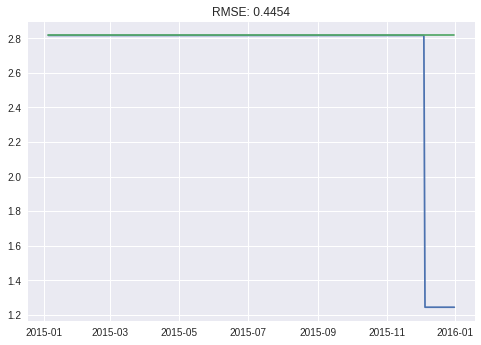

In [58]:
preds_ARIMA = np.exp(preds_log)
plt.plot(ts)
plt.plot(preds_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((preds_ARIMA-ts)**2)/len(ts)))

The results has a .443 confidences score, not very good but it makes sense with the amount of data. With more work and time with our datasets we will be able to train the agent and add our revised ARIMA model to act as a major argument to our requirements function(Functions that restrict the model form simply placing things everywhere, for example a cost model that allows the agent to spend a max budget per a station region)

The following is our agent so far but due to time constraints at HackMIT we didnt work on the training, evaluation and functions for the agent

In [0]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam

import numpy as np
import random
from collections import deque

class Agent:
	def __init__(self, state_size, is_eval=False, model_name=""):
		self.state_size = state_size # normalized previous days
		self.action_size = 3 # sit, buy, sell
		self.memory = deque(maxlen=1000)
		self.inventory = []
		self.model_name = model_name
		self.is_eval = is_eval

		self.gamma = 0.95
		self.epsilon = 1.0
		self.epsilon_min = 0.01
		self.epsilon_decay = 0.995

		self.model = load_model("models/" + model_name) if is_eval else self._model()

	def _model(self):
		model = Sequential()
		model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
		model.add(Dense(units=32, activation="relu"))
		model.add(Dense(units=8, activation="relu"))
		model.add(Dense(self.action_size, activation="linear"))
		model.compile(loss="mse", optimizer=Adam(lr=0.001))

		return model

	def act(self, state):
		if not self.is_eval and random.random() <= self.epsilon:
			return random.randrange(self.action_size)

		options = self.model.predict(state)
		return np.argmax(options[0])

	def expReplay(self, batch_size):
		mini_batch = []
		l = len(self.memory)
		for i in range(l - batch_size + 1, l):
			mini_batch.append(self.memory[i])

		for state, action, reward, next_state, done in mini_batch:
			target = reward
			if not done:
				target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

			target_f = self.model.predict(state)
			target_f[0][action] = target
			self.model.fit(state, target_f, epochs=1, verbose=0)

		if self.epsilon > self.epsilon_min:
			self.epsilon *= self.epsilon_decay 


Thanks to Ravindra for ARIMA tutorial for time-series

https://github.com/aliasvishnu



---



Acknowledgements to Google Colab Import code snippets, Tensorflow Documentation, Siraj Raval ARIMA Stock Market forcasting video, Malaria Atlas Project (MAP), IBM Research Kenya, WHO, NASA GPM, Icesat, Lansat, Consults by Ms. Wright, Ms. Battle, Ms. Casasanto


And than you to HackMIT 2018 for an amazing and Inspiring weekend, and the IBM, Microsoft mentors